### correlation of NDVI to SPI before and after drought

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
seaborn.set_style('dark')
from scipy import stats

from scipy.stats import linregress, pearsonr, spearmanr


In [2]:
spi = xr.open_dataset('/g/data/oe9/project/team-drip/Rainfall/SPI_awap/SPI_12M_masked.nc')
spi_sub = spi.isel(time=range(1,204))
spi_sub_dt = spi_sub.SPI_12M.isel(time=range(0,131))
spi_sub_dt
spi_sub_rc = spi_sub.SPI_12M.isel(time=range(131,203))
spi_sub_rc
# ET

<xarray.DataArray 'SPI_12M' (latitude: 263, longitude: 280, time: 72)>
[5302080 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2011-01-01 2011-02-01 2011-03-01 ...

In [3]:
coarse_NDVI= xr.open_dataarray('/g/data/oe9/project/team-drip/resampled_NDVI/coarse_NDVI.nc')
NDVI_dt = coarse_NDVI.isel(time=range(0,131))
NDVI_rc = coarse_NDVI.isel(time=range(131,203))
NDVI_rc

<xarray.DataArray 'ndvi' (latitude: 263, longitude: 280, time: 72)>
[5302080 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2011-01-01 2011-02-01 2011-03-01 ...

In [4]:
climatology_dt = coarse_NDVI.groupby('time.month').mean('time')
anomalies_NDVI = coarse_NDVI.groupby('time.month') - climatology_dt
anomalies_NDVI_dt = anomalies_NDVI.isel(time=range(0,131))
anomalies_NDVI_rc = anomalies_NDVI.isel(time=range(131,203))
anomalies_NDVI_rc

<xarray.DataArray 'ndvi' (latitude: 263, longitude: 280, time: 72)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2011-01-01 2011-02-01 2

### correlation during drought

In [5]:
# Start by setting up a new dataset, with empty arrays along latitude and longitude
dims = ('latitude', 'longitude')
coords = {d: spi_sub_dt[d] for d in dims}
correlation_data = {
    name: xr.DataArray(data=np.ndarray([len(spi_sub_dt[d]) for d in dims]),
                       name=name, dims=dims)
    for name in 'pearson_r pearson_p spearman_r spearman_p'.split()
}
corr_spi_sub_dt = xr.Dataset(data_vars=correlation_data, coords=coords)
corr_spi_sub_dt


<xarray.Dataset>
Dimensions:     (latitude: 263, longitude: 280)
Coordinates:
  * latitude    (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude   (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 ...
Data variables:
    pearson_r   (latitude, longitude) float64 2.254e-316 6.906e-310 ...
    pearson_p   (latitude, longitude) float64 2.219e-316 6.906e-310 ...
    spearman_r  (latitude, longitude) float64 nan nan nan nan nan nan nan ...
    spearman_p  (latitude, longitude) float64 nan nan nan nan 0.01726 ...

In [6]:
%%time
# By looping, we make a list of lists of correlations
latout = []
for lat in anomalies_NDVI_dt.latitude:
    lonout = []
    latout.append(lonout)
    for lon in anomalies_NDVI_dt.longitude:
        NDVI = anomalies_NDVI_dt.sel(latitude=lat, longitude=lon)
#         SPI = spi_1M_sub.sel(latitude=lat, longitude=lon)
        SPI_1M = spi_sub_dt.sel(latitude=lat, longitude=lon)
        mask = ~np.isinf(SPI_1M)
        subset_NDVI= NDVI.where(mask, drop=True)
        subset_SPI_1M= SPI_1M.where(mask, drop=True)
        
        val = pearsonr(subset_NDVI,subset_SPI_1M)
        try:
            # Spearman's R can fail for some values
            val += spearmanr(NDVI,SPI_1M)
        except ValueError:
            val += (np.nan, np.nan)
        lonout.append(val)
# Then we convert the lists to an array
arr = np.array(latout)
# And finally insert the pieces into our correlation dataset
corr_spi_sub_dt.pearson_r[:] = arr[..., 0]
corr_spi_sub_dt.pearson_p[:] = arr[..., 1]
corr_spi_sub_dt.spearman_r[:] = arr[..., 2]
corr_spi_sub_dt.spearman_p[:] = arr[..., 3]

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return

CPU times: user 13min 56s, sys: 261 ms, total: 13min 56s
Wall time: 13min 56s


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


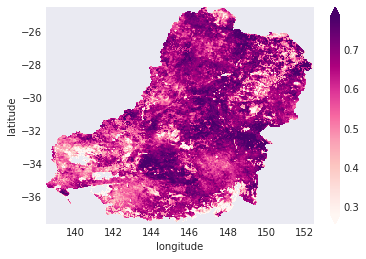

In [7]:
SIGNIFICANT = 0.05  # Choose your own!
corr_spi_sub_dt.pearson_r.where(corr_spi_sub_dt.pearson_p < 0.05).plot.imshow(robust=True,cmap = 'RdPu')


### correlation after drought

In [8]:
dims = ('latitude', 'longitude')
coords = {d: spi_sub_dt[d] for d in dims}
correlation_data = {
    name: xr.DataArray(data=np.ndarray([len(spi_sub_rc[d]) for d in dims]),
                       name=name, dims=dims)
    for name in 'pearson_r pearson_p spearman_r spearman_p'.split()
}
corr_spi_sub_rc = xr.Dataset(data_vars=correlation_data, coords=coords)
corr_spi_sub_rc

<xarray.Dataset>
Dimensions:     (latitude: 263, longitude: 280)
Coordinates:
  * latitude    (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude   (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 ...
Data variables:
    pearson_r   (latitude, longitude) float64 2.914e-316 9.881e-324 ...
    pearson_p   (latitude, longitude) float64 1.396e+17 1.396e+17 1.396e+17 ...
    spearman_r  (latitude, longitude) float64 9.733e-322 9.782e-322 ...
    spearman_p  (latitude, longitude) float64 256.0 256.0 256.0 256.0 256.0 ...

In [9]:
%%time
# By looping, we make a list of lists of correlations
latout = []
for lat in anomalies_NDVI_rc.latitude:
    lonout = []
    latout.append(lonout)
    for lon in anomalies_NDVI_rc.longitude:
        NDVI = anomalies_NDVI_rc.sel(latitude=lat, longitude=lon)
#         SPI = spi_1M_sub.sel(latitude=lat, longitude=lon)
        SPI_1M = spi_sub_rc.sel(latitude=lat, longitude=lon)
        mask = ~np.isinf(SPI_1M)
        subset_NDVI= NDVI.where(mask, drop=True)
        subset_SPI_1M= SPI_1M.where(mask, drop=True)
        
        val = pearsonr(subset_NDVI,subset_SPI_1M)
        try:
            # Spearman's R can fail for some values
            val += spearmanr(NDVI,SPI_1M)
        except ValueError:
            val += (np.nan, np.nan)
        lonout.append(val)
# Then we convert the lists to an array
arr = np.array(latout)
# And finally insert the pieces into our correlation dataset
corr_spi_sub_rc.pearson_r[:] = arr[..., 0]
corr_spi_sub_rc.pearson_p[:] = arr[..., 1]
corr_spi_sub_rc.spearman_r[:] = arr[..., 2]
corr_spi_sub_rc.spearman_p[:] = arr[..., 3]

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return

CPU times: user 13min 55s, sys: 443 ms, total: 13min 55s
Wall time: 13min 55s


In [10]:
corr_spi_sub_rc

<xarray.Dataset>
Dimensions:     (latitude: 263, longitude: 280)
Coordinates:
  * latitude    (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude   (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 ...
Data variables:
    pearson_r   (latitude, longitude) float64 nan nan nan nan nan nan nan ...
    pearson_p   (latitude, longitude) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    spearman_r  (latitude, longitude) float64 nan nan nan nan nan nan nan ...
    spearman_p  (latitude, longitude) float64 nan nan nan nan nan nan nan ...

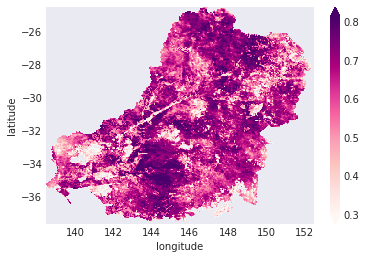

In [11]:
SIGNIFICANT = 0.05  # Choose your own!
corr_spi_sub_rc.pearson_r.where(corr_spi_sub_rc.pearson_p < 0.05).plot.imshow(robust=True,cmap = 'RdPu')


### save difference of correlation to NC

In [12]:
# outpath = '/g/data/oe9/project/team-drip/Spatial_temporal_correlation/AET_NDVI.nc'
# corr_1M_ET_NDVI.to_netcdf(outpath, mode = 'w')
corr_diff_12M_NDVI = corr_spi_sub_dt - corr_spi_sub_rc
outpath = '/g/data/oe9/project/team-drip/Spatial_temporal_correlation/SPI_VI_before_after/corr_diff_12M_NDVI.nc'
corr_diff_12M_NDVI.to_netcdf(outpath, mode = 'w')

### plot the correlation comparision map

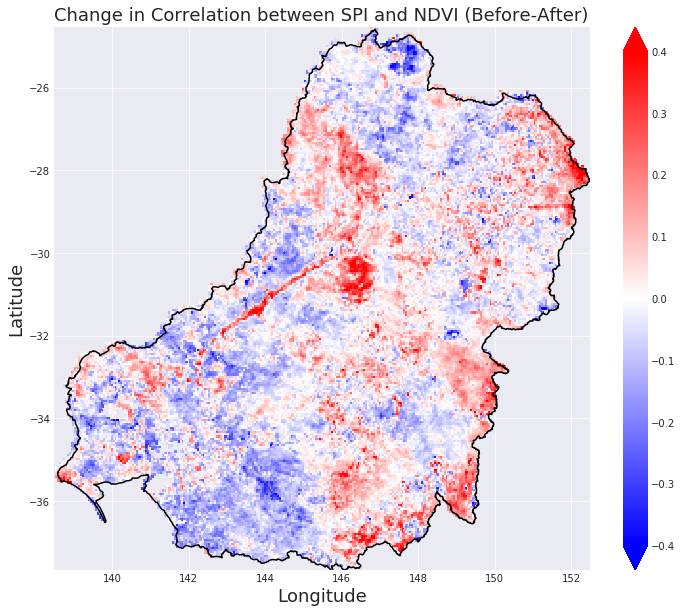

In [13]:
import matplotlib.pyplot as plt
fname = '/g/data/oe9/project/team-drip/results/spi_ndvi_cor_dif.png'

SIGNIFICANT = 0.05  # Choose your own!
corr_diff_12M = corr_spi_sub_dt - corr_spi_sub_rc
fig = plt.figure(figsize=(12, 10))
dif = corr_diff_12M.pearson_r.where(corr_diff_12M.pearson_p < 0.05)
import shapefile   

shpFilePath = '/g/data/oe9/project/team-drip/MDB_shapefile/mdb_boundary/mdb_boundary.shp' 
listx=[]
listy=[]
test = shapefile.Reader(shpFilePath)
for sr in test.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)
plt.plot(listx,listy,color='black')


dif.plot(robust=True,cmap = 'bwr',vmin = -0.4, vmax = 0.4)
plt.xlabel('Longitude',fontsize=18)
plt.ylabel('Latitude',fontsize=18)
plt.title('Change in Correlation between SPI and NDVI (Before-After)', fontsize=18)
plt.grid(True)

fig.savefig(fname, dpi=600)

# import matplotlib.pyplot as plt
# fname = '/home/599/rg6346/EVI_test.png'
# fig = plt.figure()
# plt.plot(evi_ts.time,evi_ts,'g^-',ndvi_ts.time,ndvi_ts/2,'yo-',aet_ts.time,aet_ts/200,'b--')
# fig.savefig(fname, dpi=300)